# 2장 흐름

## 2.1 THE MARCENKO–PASTUR PDF
Marcenko–Pastur PDF in python.
- mpPDF(var,q,pts)
    - input
        - var : 분산
        - q : N/T
        - pts : linspace 나누는 개수
    - output : pdf
    
## 2.2 TESTING THE MARCENKO–PASTUR THEOREM
how closely the Marcenko–Pastur distribution explains the eigenvalues of a random matrix X.
- getPCA(matrix)
    - input
        - matrix : correlation maxtirx
    - output 
        - eVal, eVec
    
- fitKDE(obs,bWidth=.25,kernel=’gaussian’,x=None)
    - input : 
        - obs : series of observation
        - bWidth : Kernel Density function의 parameter
        - kernel : Kernel Density function의 parameter
        - x
    - output : pdf 
    
## 2.3 ADD SIGNAL TO A RANDOM COVARIANCE MATRIX
covariance matrix that is not perfectly random, and hence its eigenvalues will only approximately follow the Marcenko–Pastur PDF
Out of the nCols random variables that form the covariance matrix generated by getRndCov, only nFact contain some signal.
- getRndCov(nCols,nFacts)
    - input
        - nCols : 전체 columns의 수
        - nFacts : 시그널이 있는 columns의 수
    - output
        - 전체 nCols 중 nFacts의 개수의 시그널을 담고 있는 covariance matrix
- cov2corr(cov)
    - input
        - cov : covariance matrix
    - output
        - corr : correlation matrix
        
## 2.4. FITTING THE MARCENKO–PASTUR PDF
fits the Marcenko–Pastur PDF to a random covariance matrix that contains signal
- errPDFs(var,eVal,q,bWidth,pts=1000)
    - input
        - var : mpPDF parameter
        - eVal : fitKDE parameter
        - q : mpPDF parameter
        - bWidth : fitKDE parameter
        - pts : mpPDF parameter
    - output
        - sse : sum of squares error
- findMaxEval(eVal,q,bWidth)
    - input
        - eVal
        - q
        - bWidth
    - output
        - eMax, var
        
## 2.5. DENOISING BY CONSTANT RESIDUAL EIGENVALUE
- denoisedCorr(eVal,eVec,nFacts)
    - input
        - eval : eigen values
        - eVec : eigen vectors
        - nFacts : number of facts / 2.4의 findmaxeval로부터 구함 
    - output
        - corr1 : denoised corr

## 2.6. DENOISING BY TARGETED SHRINKAGE
- denoisedCorr2(eVal, eVec, nFacts, alpha = 0)
    - input
        - eVal
        - eVec
        - nFacts
        - alpha : 비율
    - output
        - corr2 : shrinkage로 구현한 denoised corr
        
## 2.7 GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS
we compute the errors associated with estimating a minimum variance portfolio with and without denoising
- formBlockMatrix(nBlocks,bSize,bCorr)
    - input
        - nBlocks
        - bSize
        - bCorr
    - output
        - corr
- formTrueMatrix(nBlocks,bSize,bCorr)
    - input
        - nBlocks
        - bSize
        - bCorr
    - output
        - mu0
        - cov0
        
## 2.8 GENERATING THE EMPIRICAL COVARIANCE MATRIX
uses the true (nonempirical) covariance matrix to draw a random matrix X of size TxN, and it derives the associated empirical covariance matrix and vector of means. Function simCovMu receives argument nObs,
- simCovMu(mu0,cov0,nObs,shrink=False)
    - input
        - mu0 : multivariate_normal parameter
        - cov0 : multivariate_normal parameter
        - nObs :  multivariate_normal parameter(size)
        - shrink : is shrink
    - output
        - mu1
        - cov1
        
## 2.9 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
applies the methods explained in this section, to denoise the empirical covariance matrix
- corr2cov(corr,std)
    - input
        - corr
        - std
    - output
        - cov
- deNoiseCov(cov0,q,bWidth)
    - input
        - cov0 : input cov
        - q : findMaxEcal param
        - bWidth : findMaxEcal param
    - output
        - cov1 : denoised cov maxtirx

# 2.10 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
runs the following Monte Carlo experiment with 1,000 iterations: 
(1) draw a random empirical covariance matrix (shrinkage optional) with T = 1000; 
(2) denoise the empirical covariance matrix (optional);
(3) derive the minimum variance portfolio, using the function optPort
- optPort(cov,mu=None)
    - input
        - cov, mu
    - output
        - w
    

## 흐름
1. getPCA로 random correlation matrix x로부터 eigenvalue, eigenvector 생성
2. x의 크기일 때 var에 따른 mp matrix를 생성함
3. fitKDE로 1에서 생성된 empirical KDE 구함

1. getRndCov로부터 nosies + signal covariance matrix 생성
2. covariance matrix로부터 correlation matrix 도출

- 목적
    - 시그널을 포함한 랜덤 cov matrix로 mpPDF를 피팅함
    - 이론적 mpPDF와 관측값 사이의 sse가 가장 작은 분산 찾음 
1. 목적함수로 errorPDFs
2. findMaxEval로 목적함수를 최소화하는 eigenvalue의 max값과 var 값을 참음

1. Detoning
2. Cov matrix 완성 / efficient frontier 생성
3. denoise 
4. shrinkage
5. detoning
6. 
7. 
8. 


## 1 Implement in python the detoning method described in Section 2.6.

2.6 Detoning

In [1]:
from scipy.optimize import minimize
from sklearn.neighbors.kde import KernelDensity

In [2]:
def mpPDF(var, q, pts):
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf

def getRndCov(nCols,nFacts):
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols))  # full rank cov
    return cov
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr

def getPCA(matrix):
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

def errPDFs(var,eVal,q,bWidth,pts=1000):
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0) ** 2)
    return sse

def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth),
                   bounds=((1E-5, 1 - 1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1. / q) ** .5) ** 2
    return eMax, var

def fitKDE(obs,bWidth=.25,kernel="gaussian",x=None):
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

In [37]:
alpha, nCols, nFact, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0)
cov = alpha * cov + (1-alpha) * getRndCov(nCols, nFact)
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)

In [39]:
pd.DataFrame(corr0)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,-0.019159,0.007912,0.034967,0.044090,-0.055985,0.001866,-0.065571,-0.065268,-0.047617,...,0.008189,0.009429,0.009056,0.036705,-0.018917,0.002485,-0.058748,0.061343,0.046293,0.034740
1,-0.019159,1.000000,-0.019233,-0.005610,0.003479,0.019570,0.001598,-0.041014,-0.010745,0.033167,...,-0.034347,-0.084466,-0.012758,-0.030298,-0.017481,0.029189,-0.003950,-0.048500,-0.015757,0.070653
2,0.007912,-0.019233,1.000000,0.054050,-0.025274,-0.015093,-0.055297,-0.013299,-0.079642,0.005305,...,-0.013221,-0.049951,0.000143,-0.001375,0.039109,0.013557,-0.003964,-0.044296,-0.043927,-0.016570
3,0.034967,-0.005610,0.054050,1.000000,0.019380,0.023214,0.050812,-0.057382,-0.004452,0.024768,...,0.001920,0.024048,-0.011969,-0.061833,0.011874,0.041615,-0.011987,0.033044,-0.042136,-0.008323
4,0.044090,0.003479,-0.025274,0.019380,1.000000,-0.044000,0.035181,-0.045178,0.004055,-0.061683,...,-0.003290,0.023395,-0.014987,0.024996,0.001560,0.010560,0.014239,-0.037597,0.035475,-0.010566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.002485,0.029189,0.013557,0.041615,0.010560,0.008323,-0.032598,0.009756,0.027089,-0.030375,...,-0.063906,-0.013638,0.076004,-0.015916,-0.020553,1.000000,-0.017530,0.031521,-0.046123,0.003439
996,-0.058748,-0.003950,-0.003964,-0.011987,0.014239,0.011759,-0.007275,0.007801,-0.024999,0.001667,...,0.012342,0.017740,-0.018282,0.019609,-0.017882,-0.017530,1.000000,0.031711,0.021161,0.034407
997,0.061343,-0.048500,-0.044296,0.033044,-0.037597,0.051055,0.011759,0.010105,0.022348,0.018853,...,-0.011223,0.021055,-0.020973,-0.050288,-0.000197,0.031521,0.031711,1.000000,-0.009909,0.017829
998,0.046293,-0.015757,-0.043927,-0.042136,0.035475,0.042258,0.038740,-0.003272,-0.039761,-0.028295,...,0.003452,0.023454,0.039290,0.074093,-0.029295,-0.046123,0.021161,-0.009909,1.000000,0.012171


함수 f를 정의하고 minimize에 넣음 
out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth),bounds=((1E-5,1-1E-5),))

In [4]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [5]:
def detonedCorr(eVal, eVec, nMarket=1):
    eValM, eVecM = eVal[:nMarket, :nMarket], eVec[:, :nMarket] ## nmarket 
    corr1 = np.dot(eVec, eVal).dot(eVec.T) - np.dot(eVecM, eValM).dot(eVecM.T)
    corr1 = cov2corr(corr1)
    return corr1

## market의 개수 정의
nMarket = 1
corr1 = detonedCorr(eVal0, eVec0, nMarket)
eVal1, eVec1 = getPCA(corr1)

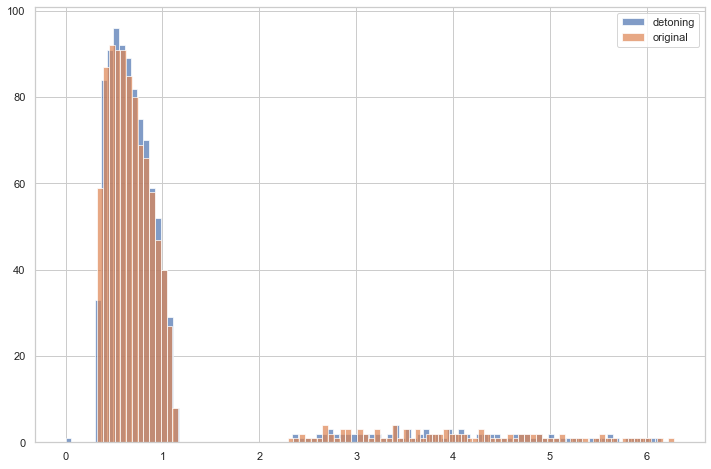

In [9]:
fig = plt.figure(figsize = (12, 8))
plt.hist(np.diag(eVal1), label = "detoning", bins = 100, alpha= 0.7)
plt.hist(np.diag(eVal0), label = "original", bins = 100, alpha= 0.7)
plt.legend()

In [45]:
np.sum(np.diag(eVal1 - eVal0))

3.608224830031759e-14

1. 한 시장 내에 존재하는 기업들은 공통의 움직임(Market condition)을 가진다
2. Market condition은 기업들 사이의 선형 관계를 의미하기 때문에 correlation을 구하는 안 좋은 영향을 끼친다
3. 이를 제거해야 한다.
3.1. PCA에서 첫번째 요소는 해당 매트릭스에서 가장 큰 공통 요소를 의미한다.
3.2. 이를 market condition이라고 생각할 수 있다.
3.3. 이 값을 제거할 경우 market condition이 제거된 기업들 간의 관계만 파악할 수 있다.

## 2 Using a series of matrix of stock returns:  
### a Compute the covariance matrix. What is the condition number of the correlation matrix?  

In [6]:
from os import listdir
from os.path import isfile, join
import datetime as dt

import matplotlib
from scipy.optimize import minimize
plt.rcParams["font.family"] = 'NanumMyeongjo'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (14,4)
matplotlib.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [46]:
path_ls = ['./005380_1M_20200517_20200814', "./005930_1M_20200517_20200814",
           "./035420_1M_20200517_20200814", "./068270_1M_20200517_20200814", 
           "./105560_1M_20200517_20200814"]
col_name = ["일자", "종목코드", "체결시각", "체결수량", "현재가", 
            "매도최우선호가", "매수최우선호가" ,"매도최우선호가잔량", "매수최우선호가잔량", 
            "매도10단계호가잔량합", "매수10단계호가잔량합", "매도성향체결수량", "매수성향체결수량"]
def preprocess_df(data, col_name):
    data = data[data.체결시각 != 31000000]
    data.일자     = data.일자.astype(str)
    data.종목코드 = data.종목코드.astype(str).str.zfill(6)
    data.체결시각 = data.체결시각.astype(str).str.zfill(8)
    data["거래대금"] = data.현재가 * data.체결수량
    data.index = pd.to_datetime(data.일자 + data.체결시각, format="%Y%m%d%H%M%S%f")
    data.index.name = "시각"    
    return data[set(col_name + ["거래대금"]) - set(["일자", "체결시각"])]
def time_bar(df, time):
    resample = df.resample(time)
    bars = resample["현재가"].ohlc()
    bars.fillna(method = "ffill",inplace = True)
    bars[["volume", "value"]] = resample[["체결수량", "거래대금"]].sum()
    return bars

def read_all_csv(path, col_name):
    df = pd.DataFrame([])
    files = [f for f in listdir(path) if isfile(join(path, f))]
    for file in files:
        data = pd.read_csv(path + "/"+file, names = col_name)
        df = pd.concat([df, data], axis = 0)
    df = preprocess_df(df, col_name)
    df = time_bar(df, "1D")
    df = df[df.volume > 0]
    return df
corp_name_ls = ["Hyundai", "Samsung", "Naver", "Celltrion", "KB"]

df = pd.DataFrame([])
for corp_name, path in zip(corp_name_ls, path_ls):
    close = read_all_csv(path, col_name).close
    close_ser = pd.Series(close, name = corp_name)
    df = pd.concat([df, close_ser], axis = 1)
df.index = df.index.astype(object)

Text(0.5, 1.0, 'Series of matrix of stock price')

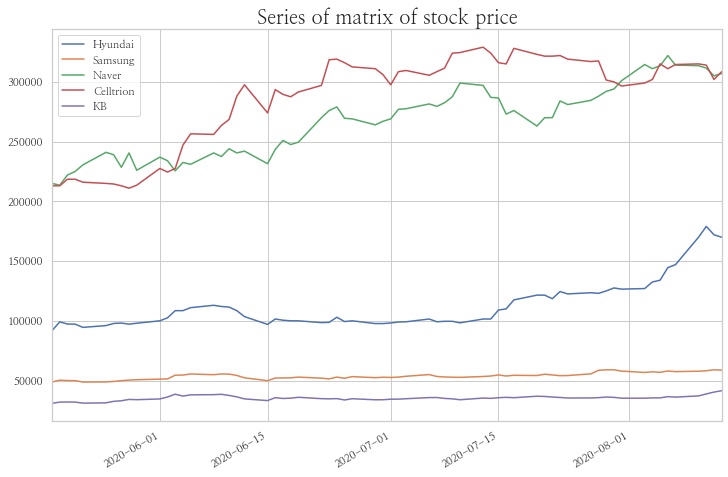

In [47]:
df.plot(figsize = (12, 8))
plt.title("Series of matrix of stock price", fontsize = 20)

In [48]:
df

,Hyundai,Samsung,Naver,Celltrion,KB
2020-05-18,91900.0,48800.0,215000.0,213000.0,31000.0
2020-05-19,99100.0,50300.0,213500.0,213000.0,31950.0
2020-05-20,97300.0,50000.0,222000.0,218500.0,32050.0
2020-05-21,97200.0,49950.0,225000.0,218500.0,32000.0
2020-05-22,94500.0,48750.0,230500.0,216000.0,31100.0
...,...,...,...,...,...
2020-08-07,147000.0,57500.0,314000.0,314500.0,36150.0
2020-08-10,170000.0,57800.0,313500.0,315000.0,37150.0
2020-08-11,179000.0,58200.0,311500.0,314000.0,38800.0
2020-08-12,172000.0,59000.0,305000.0,302000.0,40350.0


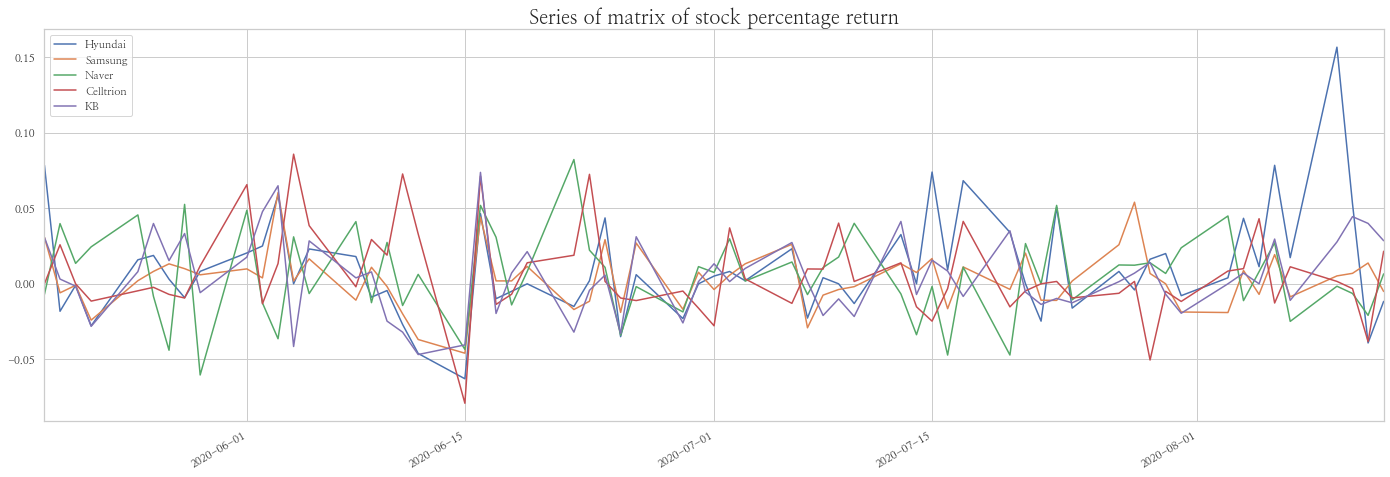


 condition number of the correlation matrix : 11 



,Hyundai,Samsung,Naver,Celltrion,KB
2020-05-19 00:00:00,0.078346,0.030738,-0.006977,0.000000,0.030645
2020-05-20 00:00:00,-0.018163,-0.005964,0.039813,0.025822,0.003130
2020-05-21 00:00:00,-0.001028,-0.001000,0.013514,0.000000,-0.001560
2020-05-22 00:00:00,-0.027778,-0.024024,0.024444,-0.011442,-0.028125
2020-05-25 00:00:00,0.015873,0.002051,0.045553,-0.004630,0.008039


In [9]:
pct_return = df.pct_change().dropna()
pct_return.plot(figsize = (24, 8))
plt.title("Series of matrix of stock percentage return", fontsize = 20)
plt.show()
cov = pct_return.cov()
print(f"\n condition number of the correlation matrix : {round(np.linalg.cond(cov))} \n")
pct_return.head()

In [133]:
pct_return.head()

,Hyundai,Samsung,Naver,Celltrion,KB
2020-05-19 00:00:00,0.078346,0.030738,-0.006977,0.000000,0.030645
2020-05-20 00:00:00,-0.018163,-0.005964,0.039813,0.025822,0.003130
2020-05-21 00:00:00,-0.001028,-0.001000,0.013514,0.000000,-0.001560
2020-05-22 00:00:00,-0.027778,-0.024024,0.024444,-0.011442,-0.028125
2020-05-25 00:00:00,0.015873,0.002051,0.045553,-0.004630,0.008039


In [136]:
log_return.head()

,Hyundai,Samsung,Naver,Celltrion,KB
2020-05-18 00:00:00,0.075428,0.030275,-0.007001,0.000000,0.030185
2020-05-19 00:00:00,-0.018330,-0.005982,0.039041,0.025494,0.003125
2020-05-20 00:00:00,-0.001028,-0.001001,0.013423,0.000000,-0.001561
2020-05-21 00:00:00,-0.028171,-0.024317,0.024150,-0.011508,-0.028528
2020-05-22 00:00:00,0.015748,0.002049,0.044546,-0.004640,0.008006


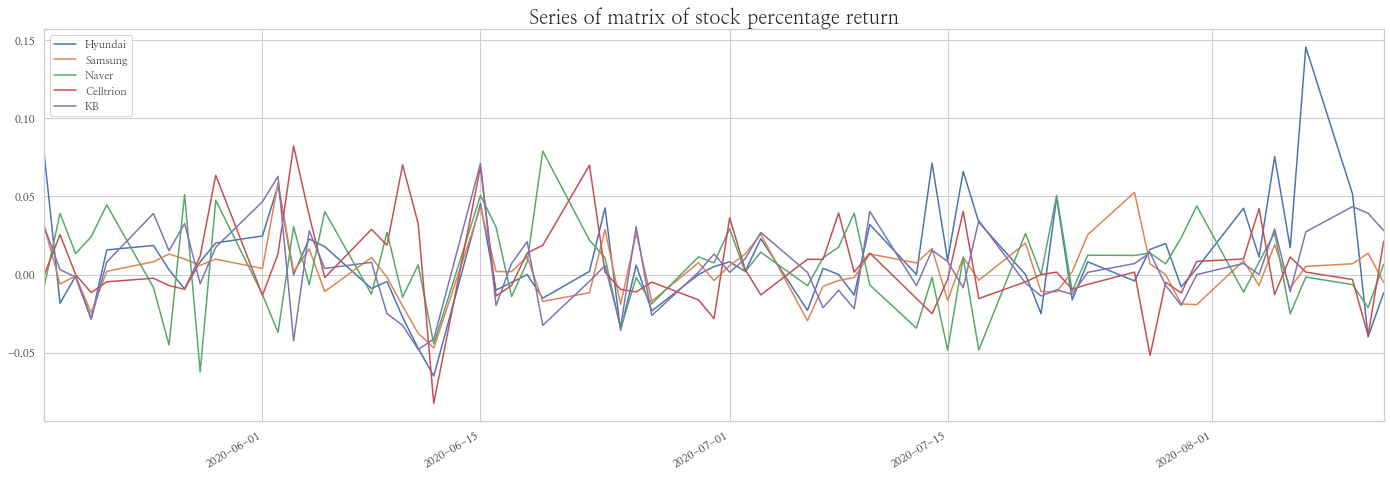


 condition number of the correlation matrix : 11 



,Hyundai,Samsung,Naver,Celltrion,KB
2020-05-18 00:00:00,0.075428,0.030275,-0.007001,0.000000,0.030185
2020-05-19 00:00:00,-0.018330,-0.005982,0.039041,0.025494,0.003125
2020-05-20 00:00:00,-0.001028,-0.001001,0.013423,0.000000,-0.001561
2020-05-21 00:00:00,-0.028171,-0.024317,0.024150,-0.011508,-0.028528
2020-05-22 00:00:00,0.015748,0.002049,0.044546,-0.004640,0.008006


In [135]:
log_return = (np.log(df.shift(-1)) - np.log(df)).dropna()
log_return.plot(figsize = (24, 8))
plt.title("Series of matrix of stock percentage return", fontsize = 20)
plt.show()
cov = log_return.cov()
print(f"\n condition number of the correlation matrix : {round(np.linalg.cond(cov))} \n")
log_return.head()

### b Compute one hundred efficient frontiers by drawing one hundred alternative vectors of expected returns from a Normal distribution with mean 10% and standard deviation 10%.

#### one hundred alternative vectors of expected returns
- Normal distribution with $\mu$ = 10 % and $\sigma$ = 10%

- denoising과 detoning은 eVal,eVec nFact가 필요함 
- eVal, eVec : getPCA를 통해 구함
    - getPCA
        -input
            - corr
- nFact : findMaxEval를 통해 구함 
    - findMaxEval
        - input
            - np.diag(eVal)
            - q
            - bWidth : 0.01

In [137]:
N = 5
mean = 0.1
std = 0.1
mu0 = np.random.normal(mean, std, N)
cov0 = log_return.cov()
print(f"\n condition number of the correlation matrix : {round(np.linalg.cond(cov0))} \n")


 condition number of the correlation matrix : 11 



In [138]:
mu0 = np.random.normal(mean, std, N)

In [139]:
def simCovMu(mu0,cov0,nObs,shrink=False):
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    cov1=np.cov(x,rowvar=0)
    return mu1,cov1



In [165]:
# nObs : asset 의 수?
# nTral : 시뮬레이션 수 
nObs, nTrials, bWidth, shrink, minVarPortf=5,63, .01, True, True

In [166]:
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nTrials),dtype=float)

w1_d=w1.copy(deep=True)

In [167]:
w1.columns = log_return.columns

In [168]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

In [169]:
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

In [170]:
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

In [171]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

In [172]:
def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov

In [173]:
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth)
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

In [174]:
w1

,Hyundai,Samsung,Naver,Celltrion,KB
0,-0.061158,0.536893,0.265443,-0.134974,0.393796
1,0.012932,-1.142398,-4.524717,7.179413,-0.525229
2,0.057938,1.140950,-0.232111,0.317302,-0.284080
3,-0.006219,1.625481,-0.413025,0.448874,-0.655111
4,-0.848363,0.592269,-0.096009,0.981661,0.370441
...,...,...,...,...,...
58,-1.144590,1.534121,0.328945,-0.001773,0.283297
59,-0.363909,0.600902,0.101749,0.588154,0.073104
60,0.723853,-1.238238,0.312193,0.650296,0.551896
61,-1.022266,1.172347,1.583881,-2.105178,1.371216


Hyundai      0.615097
Samsung      0.184709
Naver        0.356210
Celltrion    0.370430
KB           0.291706
dtype: float64

In [191]:
pd.Series(np.dot(w1, log_return.sum())).mean()

0.3386517657585631

In [192]:
pd.Series(np.dot(w1_d, log_return.sum())).mean()

0.3127578210097816

In [40]:
eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth=.01)
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

In [18]:
log_return.corr()

,Hyundai,Samsung,Naver,Celltrion,KB
Hyundai,1.000000,0.517081,0.037293,0.088262,0.550669
Samsung,0.517081,1.000000,0.011627,0.071512,0.674203
Naver,0.037293,0.011627,1.000000,0.300971,-0.106755
Celltrion,0.088262,0.071512,0.300971,1.000000,-0.061519
KB,0.550669,0.674203,-0.106755,-0.061519,1.000000


In [24]:
cov = log_return.cov()

In [27]:
mu0 = np.random.normal(mean, std, (5, 1000))

In [28]:
w0 = optPort(cov, mu0)

In [20]:
a = df.iloc[:,:2]

In [25]:
a.columns = ["mean", "std"]

In [27]:
a["std"]= np.abs(a["std"])

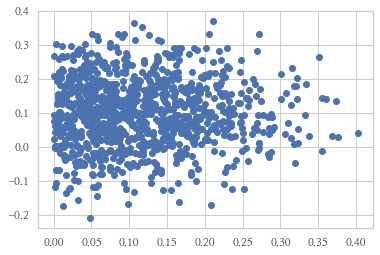

In [35]:
plt.scatter(a.iloc[:,1], a.iloc[:,0])

In [11]:
port_df = pd.concat([df.mean(), df.std()], axis = 1)
port_df.columns = ["$\mu$", "$\sigma$"]
port_df.head()

,$\mu$,$\sigma$
portfolio_0,0.100136,0.098307
portfolio_1,0.099859,0.099023
portfolio_2,0.105609,0.100572
portfolio_3,0.101964,0.102433
portfolio_4,0.095780,0.099730


In [12]:
port_df

,$\mu$,$\sigma$
portfolio_0,0.100136,0.098307
portfolio_1,0.099859,0.099023
portfolio_2,0.105609,0.100572
portfolio_3,0.101964,0.102433
portfolio_4,0.095780,0.099730
...,...,...
portfolio_995,0.100802,0.097758
portfolio_996,0.098360,0.101012
portfolio_997,0.100350,0.099846
portfolio_998,0.098107,0.098554


In [27]:
port_df = port_df.sort_values("$\sigma$")
d = pd.DataFrame([])
mu = 0
for i in range(len(port_df)):
    if port_df.iloc[i, 0] > mu:
        mu = port_df.iloc[i, 0]
        d = d.append(port_df.iloc[i, :])

In [28]:
d

,$\mu$,$\sigma$
portfolio_297,0.101184,0.091955
portfolio_968,0.101794,0.094086
portfolio_216,0.103279,0.094889
portfolio_84,0.108659,0.095259
portfolio_856,0.110653,0.098517


## T X N

Text(0.5, 0, '$\\sigma$')

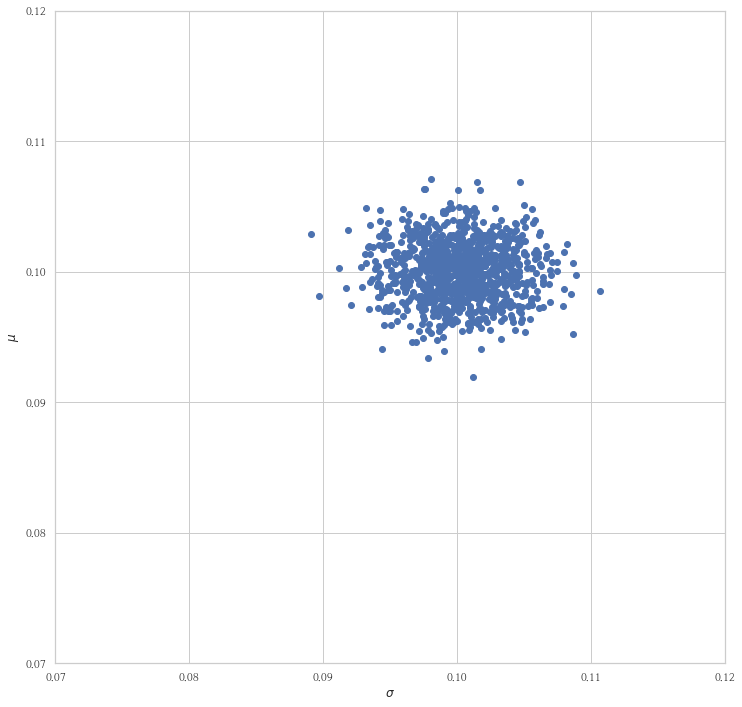

In [37]:
fig = plt.figure(figsize = (12, 12))
plt.scatter(port_df.iloc[:,0], port_df.iloc[:,1])
plt.xlim(0.07, 0.12)
plt.ylim(0.07, 0.12)
plt.ylabel("$\mu$")
plt.xlabel("$\sigma$")


In [17]:
port_df = port_df.sort_values("$\sigma$")
mu_ls = []
mu = 0
for i in range(len(port_df)):
    if port_df.iloc[i, 0] > mu:
        mu = port_df.iloc[i, 0]
        mu_ls.append(port_df.iloc[i, 0])

In [11]:
import scipy.optimize as opt

### c. Compute the variance of the errors against the mean efficient frontier.

## 3 Repeat Exercise 2, where this time you denoise the covariance matrix before computing the one hundred efficient frontiers.
### a. What is the value of $\sigma^2$ implied by the Marcenko–Pastur distribution?

### b. How many eigenvalues are associated with random components?

### c. Is the variance of the errors significantly higher or lower? Why?

# 4 Repeat Exercise 2, where this time you apply the Ledoit–Wolf shrinkage method (instead of denoising) on the covariance matrix before computing the one hundred efficient frontiers. Is the variance of the errors significantly higher or lower? Why?

## 5 Repeat Exercise 3, where this time you also detone the covariance matrix before computing the one hundred efficient frontiers. Is the variance of the errors significantly higher or lower? Why? 

## 6 What happens if you drop the components whose eigenvalues fall below a given threshold? Can you still compute the efficient frontiers? How?

## 7 Extend function fitKDE in Code Snippet 2.2, so that it estimates through cross-validation the optimal value of bWidth.